In [1]:
from Scripts.ProcessingEmbeddings import *
from Scripts.HardDebias import *
from Scripts.INLP import *
import Scripts.utils as utils

In [2]:
import codecs
import json
import numpy as np
import sklearn
from sklearn.svm import LinearSVC, SVC


In [3]:
glove=Embeddings('glove-wiki-gigaword-50')

Loading glove-wiki-gigaword-50 embeddings
vectors shape: (400000, 50), word2idx length: 400000, vocab length: 400000


In [4]:
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

In [5]:
np.isnan(vectors).any()

False

In [6]:
#Gender specific vocabulary:
gender_specific=[]
with open('./Data/male_word_file.txt') as f:
    gender_specific = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

In [7]:
# Getting a limited vocabulary to debias the embeddings.
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab, exclude=gender_specific)

100%|██████████| 400000/400000 [00:00<00:00, 617371.40it/s]


Size of limited vocabulary: 326614


In [8]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets={
    "gender" : [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
    ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'],['aunt', 'uncle']],
    
    "race":[
		["black", "caucasian", "asian"],
		["african", "caucasian", "asian"],
		["black", "white", "asian"],
		["africa", "america", "asia"],
		["africa", "america", "china"],
		["africa", "europe", "asia"]
    ], 
    "religion":[
		["judaism", "christianity", "islam"],
		["jew", "christian", "muslim"],
    ["synagogue", "church", "mosque"],
    ["torah", "bible", "quran"],
    ["rabbi", "priest", "imam"]
	]}

In [9]:
#Function to prepare the def_set_lists for the debiasing
def prepare_def_sets_subspace(list_def_sets):
  def_sets={i: v for i, v in enumerate(list_def_sets)}
  return def_sets

def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])
def_set_joined=utils.prepare_def_sets_subspace(def_sets["gender"]+ def_sets["race"])

### INLP

In [13]:
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 50)


In [14]:
num_vectors_per_class = 7500

gender_direction = identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)
gender_direction = np.squeeze(gender_direction)

gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
fem_words_and_scores, masc_words_and_scores, neut_words_and_scores = getting_classes_for_INLP(
    gender_vector=gender_direction, model=model_original, n=7500)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))

#getting the vectors corresponding to masc_words from the dict_vec_cleaned
masc_vecs=[vector for word, vector in dict_vec_cleaned.items() if word in masc_words]
fem_vecs=[vector for word, vector in dict_vec_cleaned.items() if word in fem_words]
neut_vecs=[vector for word, vector in dict_vec_cleaned.items() if word in neut_words]

#turn the list of vectors into a numpy array
masc_vecs=np.array(masc_vecs)
fem_vecs=np.array(fem_vecs)
neut_vecs=np.array(neut_vecs)

#masc_vecs, fem_vecs = model_original.get_vectors_from_list(masc_words), model_original.get_vectors_from_list(fem_words)
#neut_vecs = model_original.get_vectors_from_list(neut_words)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.zeros(n, dtype = int),
                                                  np.ones(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC:",masc_words[:50] )
print("-------------------------")
print("TOP FEM:", fem_words[:50])
print("-------------------------")
print("Random Neutral:", neut_words[:50])

Length of vectors set: 2
Running PCA with 1 components
TOP MASC: ('inienger', 'boonyaratkalin', 'abdulsalami', 'jets', 'sonthi', 'scuds', 'voreqe', 'technicals', 'strategists', 'fired', 'valiquette', 'tactic', 'patriot', 'defensive', 'singirok', 'kassam', 'greifeld', 'offensive', 'boonyaratglin', 'staubach', 'tactics', 'dannatt', 'sacking', 'kfir', 'firing', 'linemen', 'abdulsalam', 'lillee', 'midlevel', 'strike', 'volcanologists', 'commentators', 'chiefs', 'postolos', 'interception', 'preemptive', 'receivers', 'emptive', 'pundits', 'counterattacks', 'gunships', 'feehery', 'defense', 'incoming', 'quarterbacks', 'halutz', 'rushers', 'hurtt', 'gunship', 'faneca')
-------------------------
TOP FEM: ('vulva', 'ilirska', 'sopra', 'seacole', 'konstantinovna', 'phagan', 'ivanovna', 'chromatids', 'sistership', 'lactating', 'aldermanbury', 'chromatid', 'antipolis', 'masumeh', 'ruwart', 'benedicta', 'agia', 'dasi', 'triada', 'maharani', 'gothel', 'woolnoth', 'miscarries', 'popova', 'mizzenmast',

In [15]:
#random.seed(42)
np.random.seed(42)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 10716; Dev size: 4593; Test size: 6562


In [16]:
gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'penalty': 'l2','fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'penalty': 'l2','fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
dropout_rate = 0


In [18]:
P, rowspace_projs, Ws = get_debiasing_projection(gender_clf, params, n, 50, min_acc, 
                                    X_train, Y_train, X_dev, Y_dev, 
                                    is_autoregressive=True, Y_train_main=None, Y_dev_main=None, 
                                       dropout_rate = 0)

iteration: 34, accuracy: 0.31678641410842584: 100%|██████████| 35/35 [00:01<00:00, 22.34it/s]


## Evaluation

In [19]:
from Scripts.Visualization import *
from Scripts.Evaluation import *

## Pre_post bias selected words

In [11]:
# To compute the gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']
occupations = ['assistant', 'secretary', 'data scientist', 'scientist', 'politician', 'janitor', 'hairdresser', 'teacher', 'bartender', 'midwife', 'doctor', 'ballerina', 'dancer', 'pediatrician', 'surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists', 'carpenter', 'clerk', 'manager', 'supervisor', 'driver',
               'software developer', 'lawyer', 'pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro', 'lecturer', 'salesperson', 'homemaker', 'receptionist', 'librarian', 'nanny', 'bookkeeper', 'stylist', 'housekeeper', 'guidance counselor', 'skipper', 'protege', 'philosopher', 'captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher', 'pilot', 'boss']



In [20]:
# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
gender_bias_original = compute_gender_simple_bias(
    dict_vec_cleaned, he_embed, she_embed)


In [21]:
debiased_vectors=(P.dot(vectors_cleaned.T)).T
debiased_dict=get_debiased_dict(debiased_vectors, word2idx_cleaned)
debiased_vocab = list(debiased_dict.keys())



In [22]:
gender_bias_after_debiasing = compute_gender_simple_bias(
    debiased_dict, he_embed, she_embed)


In [23]:
bias_df = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, occupations, vocab_cleaned, debiased_vocab)
plot_bias_bar(
    bias_df, plot_title="INLP bias", words_title='words')


## Clustering

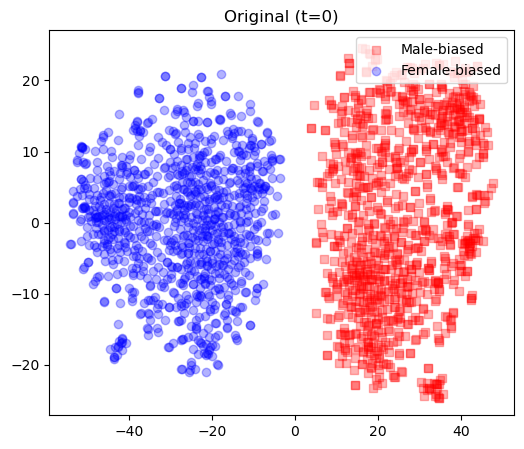

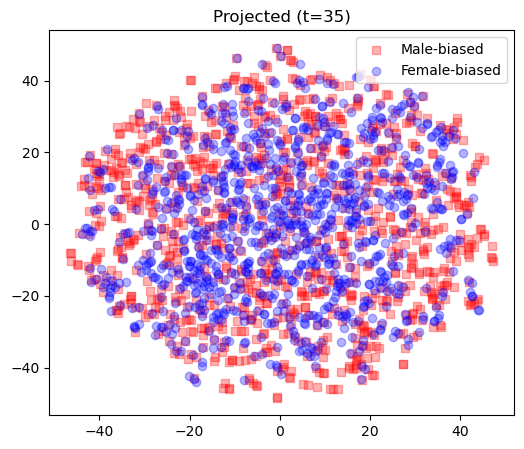

V-measure-before (TSNE space): 1.0
V-measure-after (TSNE space): 1.8296804605893213e-05
V-measure-before (original space): 1.0
V-measure-after (original space): 3.97369989183242e-05
Rank before: 50; Rank after: 8


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

In [24]:

# remove neutral class, keep only male and female biased
X_dev = X_dev[Y_dev != -1]
X_train = X_train[Y_train != -1]
X_test = X_test[Y_test != -1]


Y_dev = Y_dev[Y_dev != -1]
Y_train = Y_train[Y_train != -1]
Y_test = Y_test[Y_test != -1]


M = 2000
ind2label = {1: "Female-biased", 0: "Male-biased"}
#tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )
tsne_before = tsne(
    all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title="Original (t=0)", ind2label=ind2label)


X_dev_cleaned = (P.dot(X_dev.T)).T
X_test_cleaned = (P.dot(X_test.T)).T
X_trained_cleaned = (P.dot(X_train.T)).T
all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T

#tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M],
                  title="Projected (t={})".format(n), ind2label=ind2label)

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before,
      all_significantly_biased_labels[:M])))
print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after,
      all_significantly_biased_labels[:M])))

#print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
#print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-before (original space): {}".format(compute_v_measure(
    all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k=2))
print("V-measure-after (original space): {}".format(
    compute_v_measure(X_test_cleaned[:M], Y_test[:M]), k=2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))


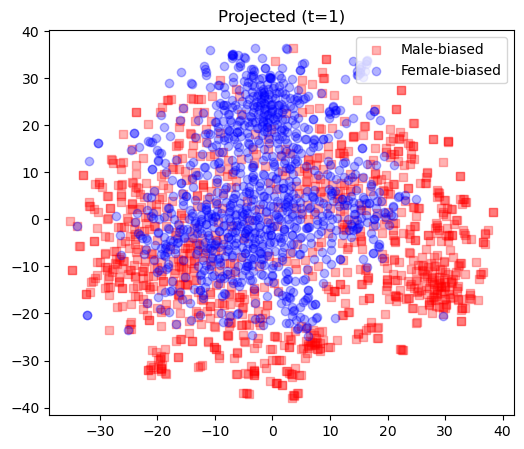

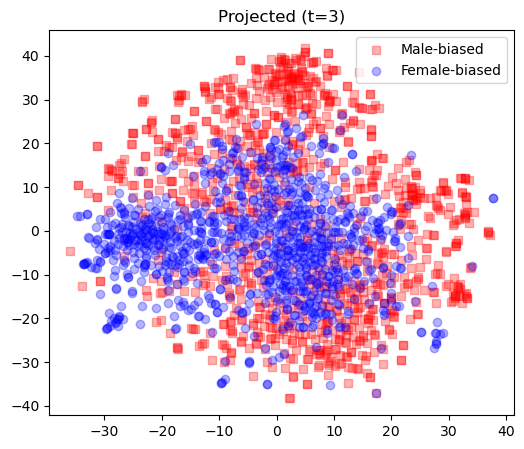

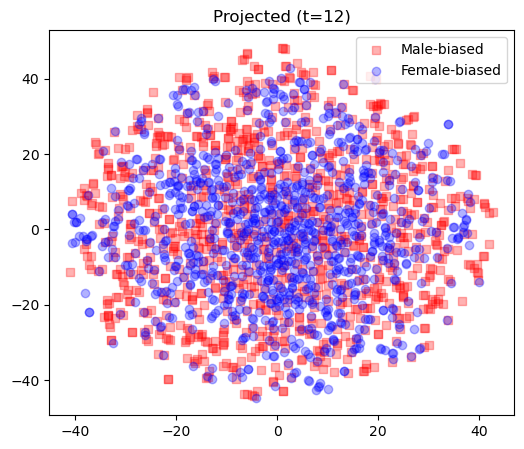

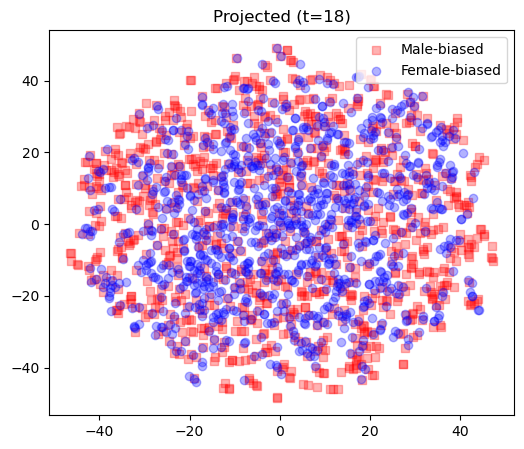

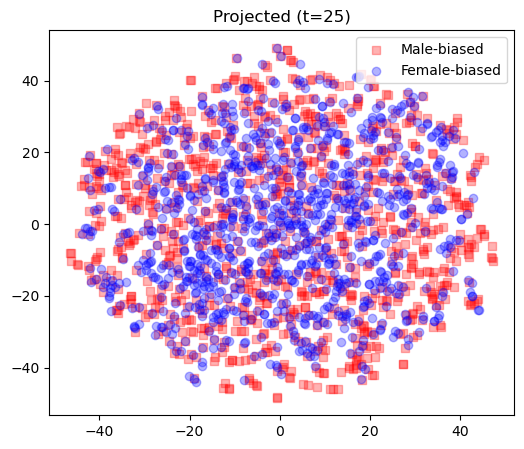

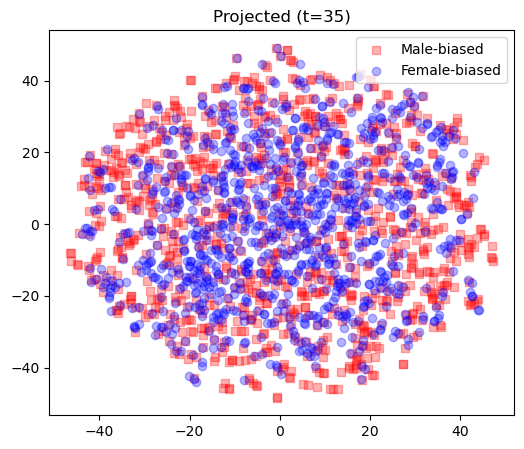

In [29]:
for t in [1, 3, 12, 18, 25, 35]:
    p = get_projection_to_intersection_of_nullspaces(rowspace_projs[:t], 50)
    tsne_after = tsne(p.dot(all_significantly_biased_vecs[:M].T).T, all_significantly_biased_labels[:M], title="Projected (t={})".format(
        t), ind2label=ind2label)


## Random Words

In [26]:
from collections import defaultdict
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=50)

#setting parameters for the gensim method "most_similar"
topn = 3


In [27]:
random_words


array(['criquette', 'patchett', 'cavalera', 'bagno', 'lightings', 'grd',
       'khala', 'vestar', 'herries', 'threating', 'hamiota', 'expeditor',
       'solvent', 'hartinger', 'talish', 'shellharbour', 'nzaid',
       'bruschetta', 'bulstrode', 'femen', 'celler', 'transference',
       'desegregation', 'dally', 'mouthing', 'miev', 'flulike',
       'moneytalk', 'kinsale', 'food', 'camphill', 'panis', 'pipestone',
       'sonntagszeitung', 'taya', 'miklós', 'poulett', 'atrox', 'yeroen',
       'fedorets', 'inniskeen', 'mccoys', 'iga', 'superdome',
       'filderstadt', 'kinnear', 'saxifragaceae', 'stridently', 'attire',
       'stanback'], dtype='<U19')

In [27]:
model_debiased = create_KeyedVectors(debiased_vectors, debiased_vocab, 300)


In [28]:
finding_neighbors_before_after(
    random_words, model_original, model_debiased, topn=3)


----------------------------------
word: texana
 most-similar-before: ('texensis', 'suaveolens', 'heliothis')
 most-similar-after: ('texensis', 'spicata', 'ovalis')
----------------------------------
word: midsized
 most-similar-before: ('midsize', 'smallish', 'sedans')
 most-similar-after: ('midsize', 'sized', 'sedans')
----------------------------------
word: gnomic
 most-similar-before: ('utterances', 'understatements', 'adages')
 most-similar-after: ('skaldic', 'chapbooks', 'utterances')
----------------------------------
word: trh
 most-similar-before: ('lzma', 'enucleation', 'tsh')
 most-similar-after: ('lzma', 'gnrh', 'guozhong')
----------------------------------
word: brimeyer
 most-similar-before: ('sydbank', 'chovav', 'plodwick')
 most-similar-after: ('sydbank', 'plodwick', 'jerome')
----------------------------------
word: taiyuan
 most-similar-before: ('shijiazhuang', 'changsha', 'hohhot')
 most-similar-after: ('shijiazhuang', 'changsha', 'hohhot')
------------------------

defaultdict(dict,
            {'texana': {'before': ('texensis', 'suaveolens', 'heliothis'),
              'after': ('texensis', 'spicata', 'ovalis')},
             'midsized': {'before': ('midsize', 'smallish', 'sedans'),
              'after': ('midsize', 'sized', 'sedans')},
             'gnomic': {'before': ('utterances', 'understatements', 'adages'),
              'after': ('skaldic', 'chapbooks', 'utterances')},
             'trh': {'before': ('lzma', 'enucleation', 'tsh'),
              'after': ('lzma', 'gnrh', 'guozhong')},
             'brimeyer': {'before': ('sydbank', 'chovav', 'plodwick'),
              'after': ('sydbank', 'plodwick', 'jerome')},
             'taiyuan': {'before': ('shijiazhuang', 'changsha', 'hohhot'),
              'after': ('shijiazhuang', 'changsha', 'hohhot')},
             'weisswurst': {'before': ('morcilla',
               'utahensis',
               'chanjindamanee'),
              'after': ('sausages', 'morcilla', 'bratwurst')},
             'he

In [29]:
from sklearn.manifold import TSNE
import numpy as np

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, model_debiased, 10)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


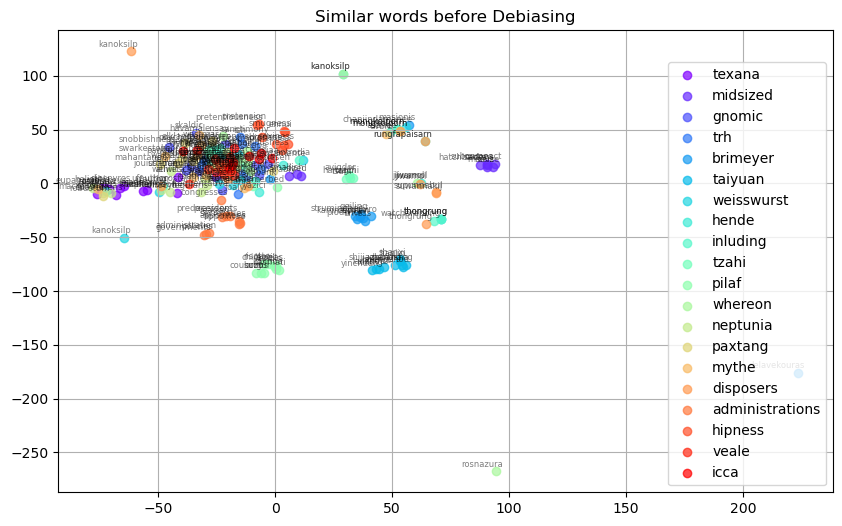

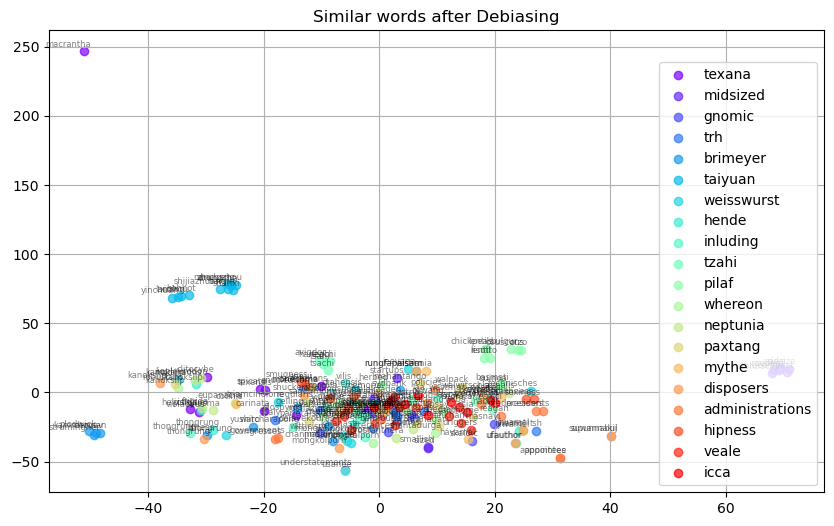

In [30]:
tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


In [31]:
gendered_names = ["ruth", "charlotte", "abigail", "sophie", "nichole", "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia"]
                 # "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike", "nurse", "secretary", "nursery"]
#words_chosen = ["miss", "mrs", "mr", "john", "rachel",
# "wife", "mom", "family", "father", "lady", "he", "she"]

gendered_words_before_and_after=finding_neighbors_before_after(gendered_names, model_original, model_debiased, topn=3)

----------------------------------
word: ruth
 most-similar-before: ('bader', 'ginsburg', 'maris')
 most-similar-after: ('bader', 'gehrig', 'dimaggio')
----------------------------------
word: charlotte
 most-similar-before: ('carolina', 'hornets', 'raleigh')
 most-similar-after: ('hornets', 'bobcats', 'raleigh')
----------------------------------
word: abigail
 most-similar-before: ('breslin', 'thernstrom', 'abby')
 most-similar-after: ('breslin', 'adams', 'thernstrom')
----------------------------------
word: sophie
 most-similar-before: ('elisabeth', 'louise', 'anne')
 most-similar-after: ('mongalvy', 'friederike', 'luise')
----------------------------------
word: nichole
 most-similar-before: ('nordeman', 'cortney', 'lestrac')
 most-similar-after: ('monroe', 'nordeman', 'warhawks')
----------------------------------
word: emma
 most-similar-before: ('emily', 'julia', 'kate')
 most-similar-after: ('bonino', 'hermione', 'samms')
----------------------------------
word: olivia
 most-s

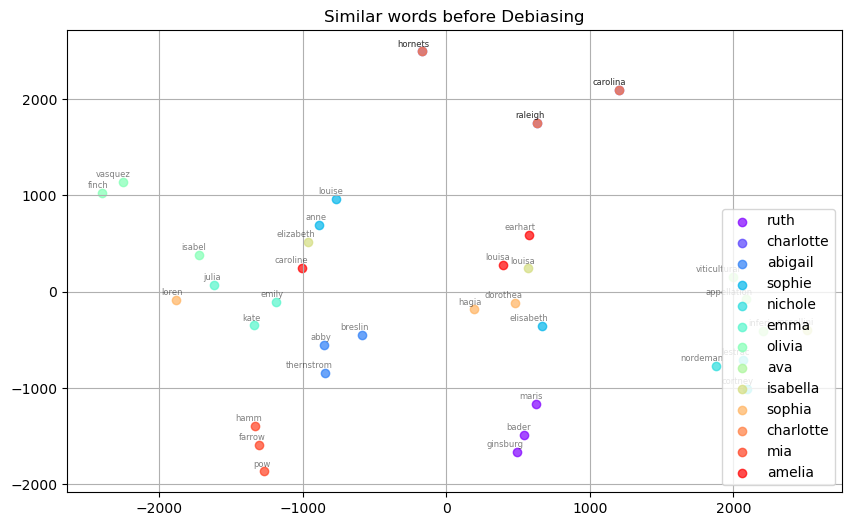

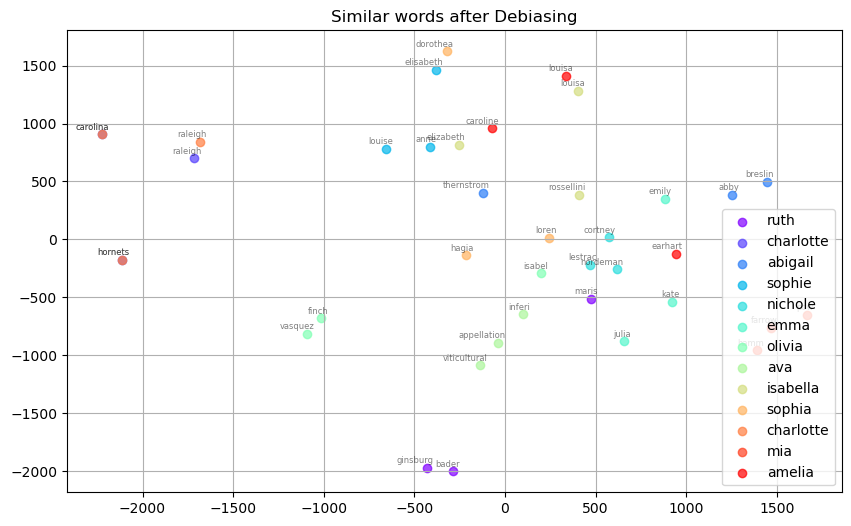

In [32]:
keys2 = gendered_names
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys2, model_original, model_debiased, topn)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words before Debiasing',
                        keys2, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys2, db_embeddings_en_2d, word_clusters, 0.7)
